**Pan-Tompkins QRS Complex Detection**

The first step in a lot of ECG processing is finding QRS complexes. The Pan-Tompkins algorithm is a series of pre-processing steps and a detection algorithm for finding these complexes. We'll can see it in action below.

# Imports

In [1]:
import glob
import os

from matplotlib import pyplot as plt
import mpld3
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

np.warnings.filterwarnings('ignore')

We will be using the ECGs in these files as examples

In [2]:
fs = 300
f0 = 'A00010.npz'
f1 = 'A01593.npz'

A simple version of the algorithm

In [3]:
def BandpassFilter(signal, fs=300):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (5, 15), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=300):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, pks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[pks])
    return pks[filtered_signal[pks] > thresh]

def LocalizeMaxima(signal, pks, fs):
    """Find R-wave peaks in the original, unfiltered signal.
    
    This function is mostly for aesthetic purposes and not part of the algorithm.
    We only do it here because we know that the R-waves are pointing up.
    """
    tpks = []
    n_samples = int(round(fs * 0.150))
    for p in pks:
        tpks.append(np.argmax(signal[p - n_samples: p + n_samples]) + p - n_samples)
    return tpks

def PanTompkinsPeaks(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    fiducial_marks = ThresholdPeaks(filtered_signal, FindPeaks(filtered_signal))
    return LocalizeMaxima(signal, fiducial_marks, fs)

Some plotting helper code

In [4]:
def Plot(x, fs, xlim=None, title=''):
    plt.figure(figsize=(12, 8))
    ts = np.arange(len(x)) / fs
    plt.plot(ts, x)
    pks = PanTompkinsPeaks(x, fs)
    plt.plot(ts[pks], x[pks], 'r.', ms=10)
    plt.xlabel('Time (sec)')
    plt.title(title)
    if xlim is not None:
        plt.xlim((ts[xlim[0]], ts[xlim[1]]))

In [5]:
mpld3.enable_notebook()

This is an example of a clean ECG signal. The QRS complexes are large, and they occur regularly. Our detector should have no problem with this signal.

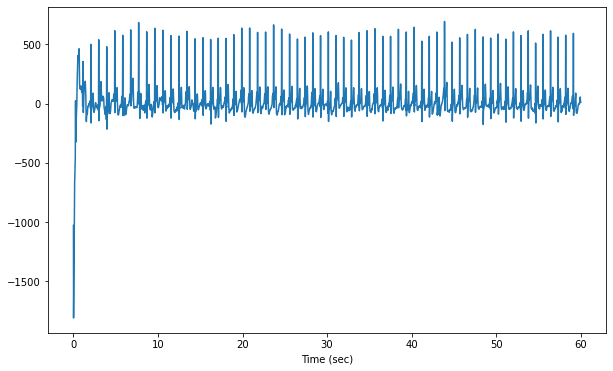

In [6]:
with np.load(f0) as f:
    v = f['ecg'] * 1000
plt.figure(figsize=(10, 6));
plt.plot(np.arange(len(v)) / fs, v)
plt.xlabel('Time (sec)');

Here, we can examine how the pre-processing steps change our signal and make it really easy for the decision algorithm to pick out the right peaks.

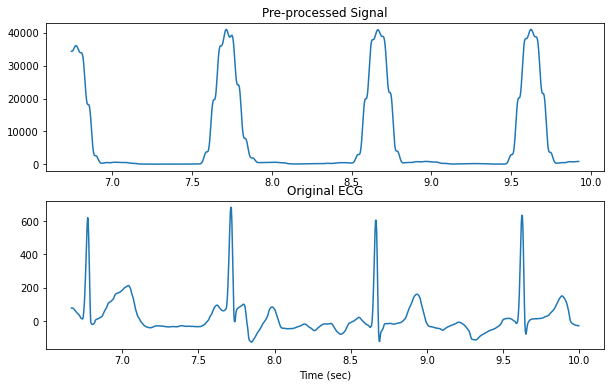

In [7]:
ts = np.arange(len(v)) / fs
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(ts[2001:3000], MovingSum(np.square(np.diff(BandpassFilter(v, 300)[2000:3000])), fs))
plt.title('Pre-processed Signal')
plt.subplot(2,1,2);
plt.plot(ts[2000:3000], v[2000:3000]);
plt.title('Original ECG')
plt.xlabel('Time (sec)');

After running Pan-Tompkins, we can see that all the peaks are detected.

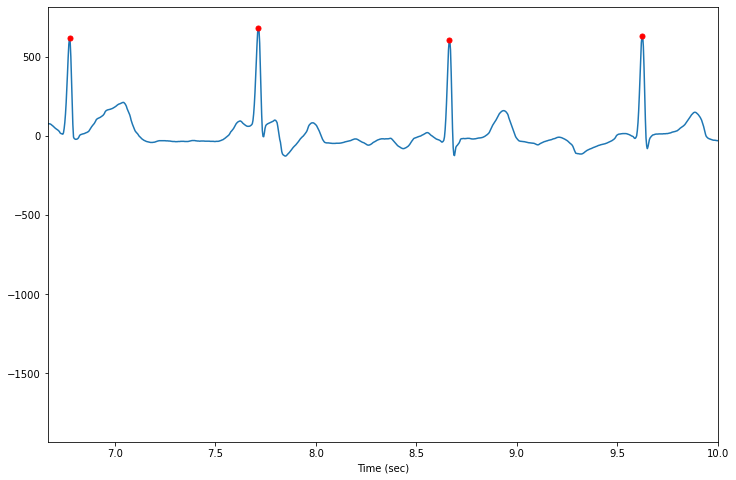

In [8]:
Plot(v, 300, (2000, 3000))

This is an example of a more difficult ECG signal. While the QRS complexes are present, they are less prominent, somtetimes even smaller than the T-waves.

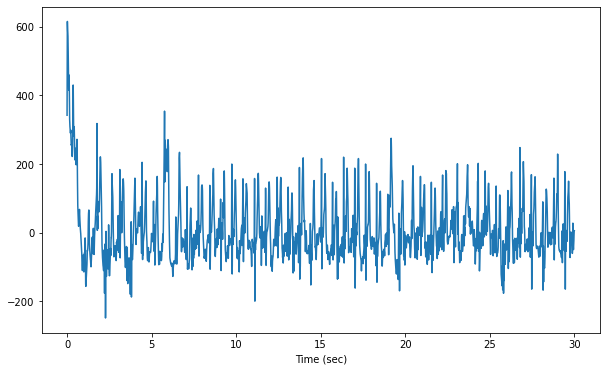

In [9]:
with np.load(f1) as f:
    v = f['ecg'] * 1000
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(v)) / fs, v)
plt.xlabel('Time (sec)');

Now, let's take a look at what each of the pre-processing steps do individually.

  - Notice that because our pass-band is so tight, the original wave is distorted quite significantly.
  - After taking the first difference, we start to capitalize on the QRS complexes' steep slopes, and flatten out other parts of the signal.
  - The squaring operation non-linearly amplifies the larger parts of the signal which puts even more separation between the QRS complexes and the T-waves.
  - Finally, the moving sum allows us to aggregate all of the energy in the QRS complex, while further flattening out the T-waves.
  - After all the pre-processing steps, we have made even the smallest QRS complex bigger than the T-wave.

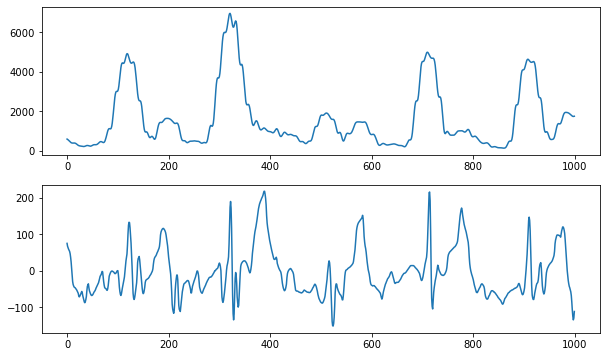

In [10]:
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(MovingSum(np.square(np.diff(BandpassFilter(v))))[3800:4800])
plt.subplot(2,1,2)
plt.plot(v[3800:4800])

Although our pre-processing steps made the QRS complex larger than the T-wave, our simple decision rule was not able to pick it out.

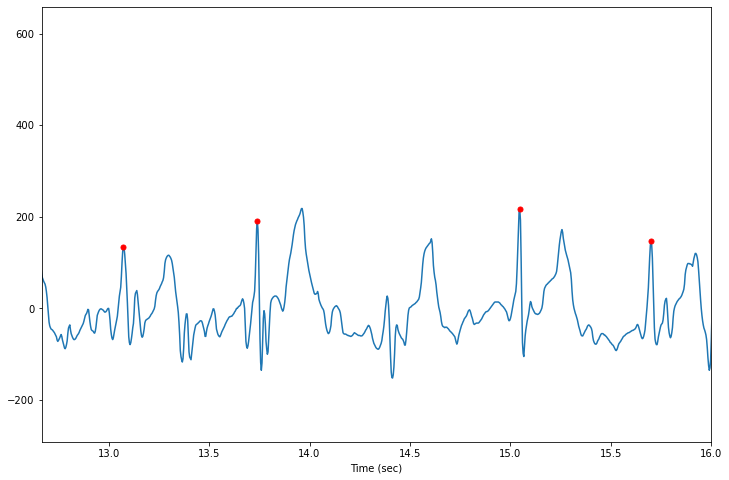

In [11]:
Plot(v, 300, (3800, 4800))

[Pan-Tompkins In Code](https://www.youtube.com/watch?v=oNFyQT--irs&t=2s&ab_channel=Udacity)